# ESS electives report

## Setup and Data Loading

In [39]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap

# Load the dataframe using the correct file name
file_path = 'data/ESS_electives_op_DEC2025.csv'
df = pd.read_csv(file_path)
print(f"Data Loaded. Shape: {df.shape}")

# Define output directory
OUTPUT_DIR = 'output'
    # Create the folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {os.path.abspath(OUTPUT_DIR)}")

# In Qualtrics exports:
# Row 0 = Column Headers (Q1, Q2...) -> df.columns
# Row 1 = Question Text ("How difficult was...") -> df.iloc[0]
# Row 2 = Import IDs -> df.iloc[1]
# Row 3+ = Actual Data -> df.iloc[2:]

questions_row = df.iloc[0]
print("Header and Question Text rows identified.")

Data Loaded. Shape: (100, 187)
Output directory set to: /Users/stefanograziosi/Documents/GitHub/ESS_electives_report/output
Header and Question Text rows identified.


## Column Mapping

In [40]:
def extract_course_info(question_text):
    """
    Parses question text to extract Course Name and Category.
    """
    if not isinstance(question_text, str):
        return None, None
    
    course_name = None
    category = None
    
    # Pattern 1: "... questions below about <Course>? - <Question>"
    match_about = re.search(r"about\s+(.*?)\?\s+-(.*)", question_text)
    
    # Pattern 2: "Would you enrol in <Course> again?"
    match_enrol = re.search(r"Would you enrol in\s+(.*?)(?: again)?\??$", question_text, re.IGNORECASE)
    
    # Pattern 3: "When did you sit the exam for <Course>?"
    match_session = re.search(r"sit the exam for\s+(.*?)\??$", question_text, re.IGNORECASE)

    if match_about:
        course_name = match_about.group(1).strip()
        sub_text = match_about.group(2).strip()
        
        if "difficult was the course" in sub_text or "hard was the course" in sub_text:
            category = "Course Difficulty"
        elif "difficult was the exam" in sub_text or "hard was the exam" in sub_text:
            category = "Exam Difficulty"
        elif "in line with what has been explained" in sub_text:
            category = "Exam Alignment"
            
    elif match_enrol:
        course_name = match_enrol.group(1).strip()
        category = "Enrol Again"
        
    elif match_session:
        course_name = match_session.group(1).strip()
        category = "Exam Session"

    return course_name, category

# Build the map
course_map = {}
for col in df.columns:
    # Skip metadata columns
    if col in ['StartDate', 'EndDate', 'ResponseId', 'Q1']: continue
        
    q_text = questions_row[col]
    course, cat = extract_course_info(q_text)
    
    if course and cat:
        if course not in course_map:
            course_map[course] = {}
        course_map[course][cat] = col

print(f"Successfully mapped {len(course_map)} courses.")

Successfully mapped 31 courses.


## Data Transformation

In [41]:
# Mappings for converting text to numbers
diff_map = {
    'Easy': 1,
    'Somewhat easy': 2,
    'Neither easy nor difficult': 3,
    'Somewhat difficult': 4,
    'Difficult': 5,
    # Handle numeric strings if they appear
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}

agree_map = {
    'Strongly disagree': 5,
    'Somewhat disagree': 4,
    'Neither agree nor disagree': 3,
    'Somewhat agree': 2,
    'Strongly agree': 1
}

records = []
# Start reading data from index 2 (skipping Question Text and Import ID rows)
data_rows = df.iloc[2:]

for idx, row in data_rows.iterrows():
    respondent_id = row['ResponseId']
    
    for course, cols in course_map.items():
        # Check if the student took this course (Difficulty column is not empty)
        c_diff_col = cols.get('Course Difficulty')
        
        if c_diff_col and pd.notna(row[c_diff_col]):
            # Get raw text values
            raw_c_diff = row.get(cols.get('Course Difficulty'))
            raw_e_diff = row.get(cols.get('Exam Difficulty'))
            raw_align  = row.get(cols.get('Exam Alignment'))
            raw_enrol  = row.get(cols.get('Enrol Again'))
            
            rec = {
                'RespondentId': respondent_id,
                'Course': course,
                'Course Difficulty': diff_map.get(raw_c_diff),
                'Exam Difficulty': diff_map.get(raw_e_diff),
                'Exam Alignment': agree_map.get(raw_align),
                'Enrol Again Text': raw_enrol
            }
            
            # Convert Enrolment to 0/1
            if isinstance(raw_enrol, str) and 'Yes' in raw_enrol:
                rec['Enrol Again'] = 1
            else:
                rec['Enrol Again'] = 0
                
            records.append(rec)

long_df = pd.DataFrame(records)
print(f"Processed {len(long_df)} feedback records.")
long_df.head()

Processed 350 feedback records.


,RespondentId,Course,Course Difficulty,Exam Difficulty,Exam Alignment,Enrol Again Text,Enrol Again
0,R_2Uby8w29FHmnnoN,Advanced Microeconomics,5,4.0,NaN,"No, but I would enrol in the second year",0
1,R_2pYgmWKvuuhnxrP,Advanced Microeconomics,4,3.0,NaN,"Yes, I would enrol again",1
2,R_8hR1FMyoeDEWzA7,Advanced Microeconomics,5,5.0,5.0,"No, I would not enrol in the course at all",0
3,R_8hR1FMyoeDEWzA7,Development Economics,3,3.0,1.0,"Yes, I would enrol again",1
4,R_8hR1FMyoeDEWzA7,Labour Economics,4,4.0,4.0,"No, I would not enrol in the course at all",0


## Analysis and visualisation

In [42]:
# 1. Aggregate Data
summary = long_df.groupby('Course').agg(
    Responses=('RespondentId', 'count'),
    Avg_Course_Difficulty=('Course Difficulty', 'mean'),
    Avg_Exam_Difficulty=('Exam Difficulty', 'mean'),
    Avg_Exam_Alignment=('Exam Alignment', 'mean'),
    Enrol_Again_Rate=('Enrol Again', 'mean')
).reset_index()

# Filter for courses with enough data (e.g., >2 responses) to make charts meaningful
summary_filtered = summary[summary['Responses'] >= 3].sort_values('Responses', ascending=False)

# 2. Save Raw Data
csv_path = os.path.join(OUTPUT_DIR, 'summary_table.csv')
summary.to_csv(csv_path, index=False)
print(f"Saved full summary to: {csv_path}")

# 3. Create a Styled Table for Display
# Scale: 1 (Green/Easy/Good) to 5 (Red/Hard/Bad)
def style_table(df):
    return df.style.background_gradient(
        cmap='RdYlGn_r', # Red-Yellow-Green Reversed (Low=Green, High=Red)
        subset=['Avg_Course_Difficulty', 'Avg_Exam_Difficulty', 'Avg_Exam_Alignment'],
        vmin=1, vmax=5
    ).background_gradient(
        cmap='RdYlGn', # Normal Green-Red (High=Green)
        subset=['Enrol_Again_Rate'],
        vmin=0, vmax=1
    ).format({
        'Avg_Course_Difficulty': '{:.2f}',
        'Avg_Exam_Difficulty': '{:.2f}',
        'Avg_Exam_Alignment': '{:.2f}',
        'Enrol_Again_Rate': '{:.0%}'
    }).set_caption("Course Feedback Summary (Green = Easy/Aligned/High Enrolment)")

# Display
style_table(summary_filtered.head(len(course_map))) # Show top all courses

Saved full summary to: output/summary_table.csv


,Course,Responses,Avg_Course_Difficulty,Avg_Exam_Difficulty,Avg_Exam_Alignment,Enrol_Again_Rate
21,Microeconometrics,57,3.77,4.04,2.61,96%
11,Foundation of Social Sciences - Module II A,45,2.16,2.23,2.18,78%
12,Foundation of Social Sciences - Module II B,32,2.28,2.68,2.03,91%
28,Time Series Analysis of Economic and Financial Data,23,3.30,3.36,2.04,78%
5,Development Economics,20,2.20,3.20,2.70,65%
1,Advanced Microeconomics,20,4.65,4.53,3.00,45%
19,Labour Economics,15,3.53,4.07,2.40,67%
8,Economics of European Integration,15,2.53,2.80,1.73,100%
17,International Macroeconomics and Finance,13,3.85,4.25,2.75,62%
14,"Globalization, Divergence, and Inequality in Historical Perspective",9,2.22,2.56,1.25,78%


### Plot 1: Difficulty Comparison

Saved plot to: output/difficulty_comparison.png


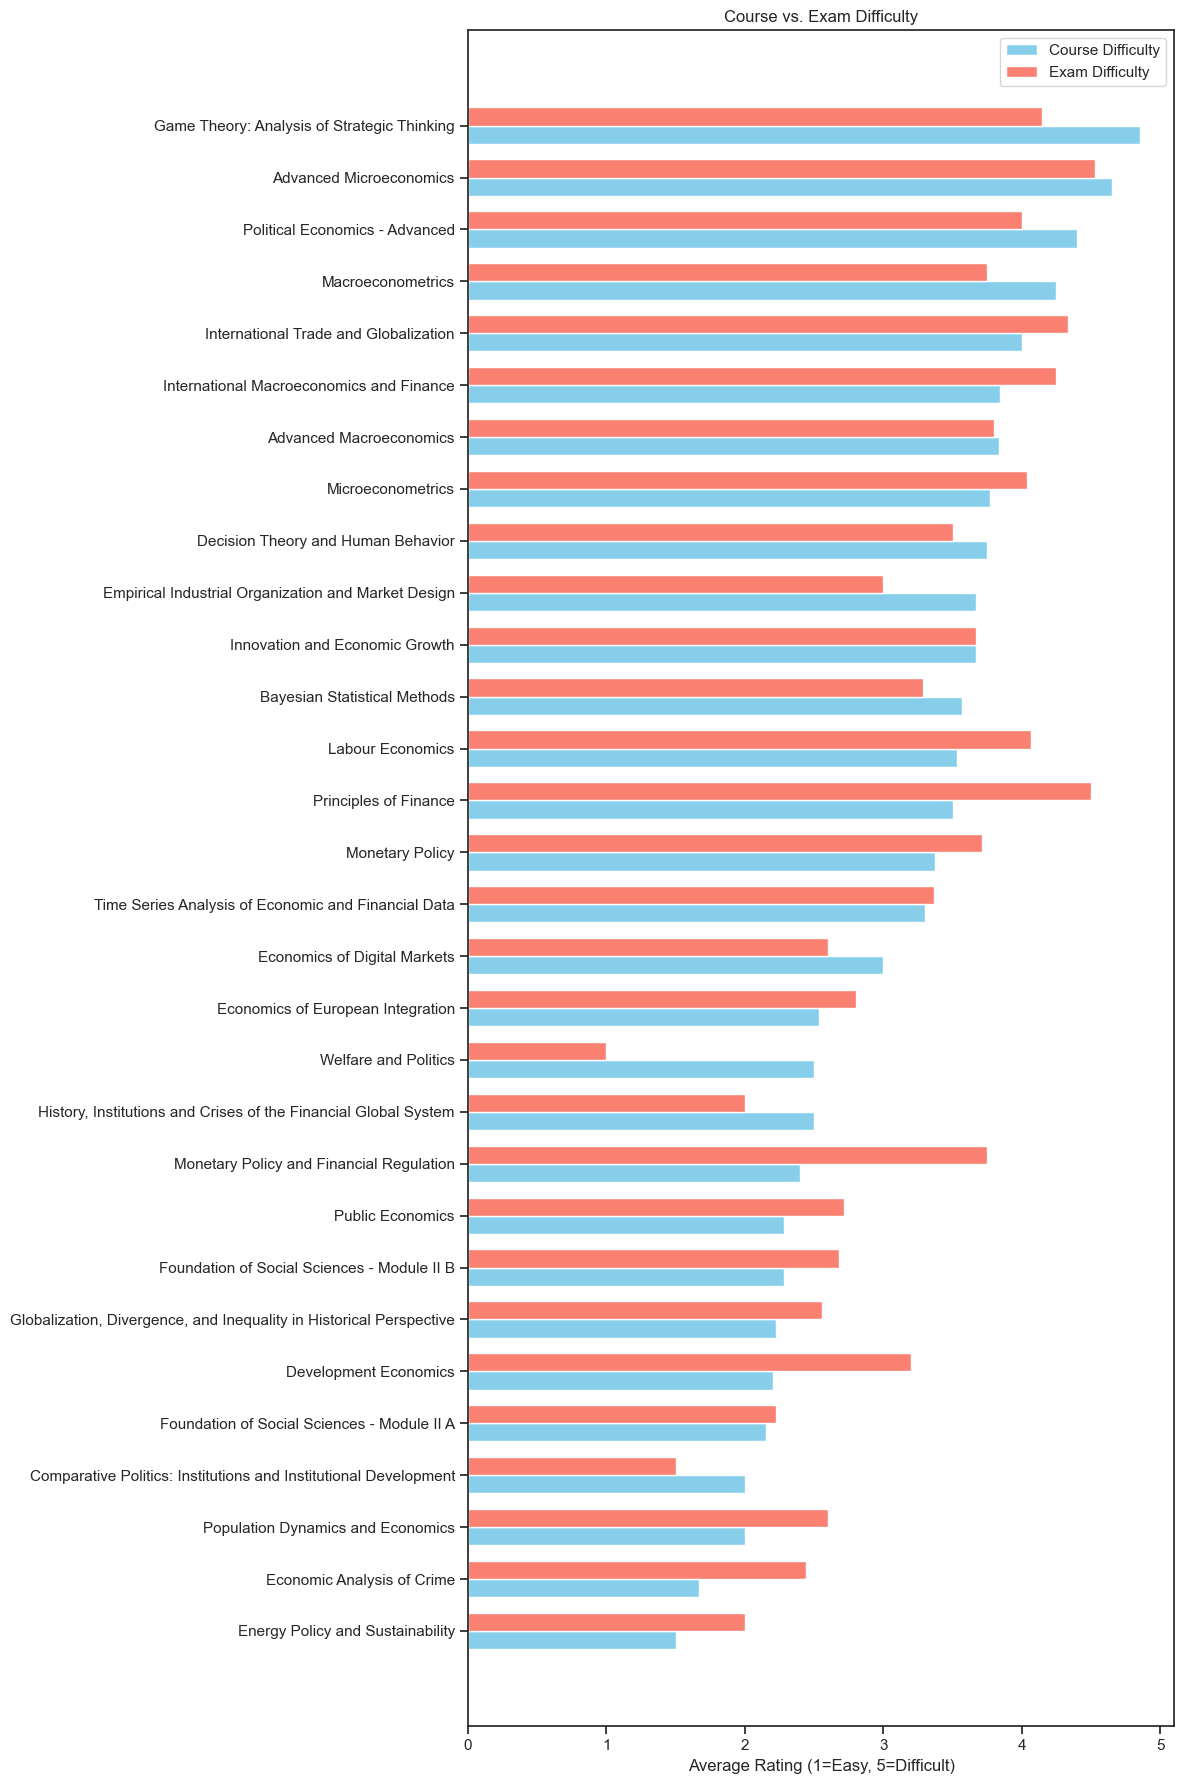

In [43]:
plt.figure(figsize=(12, len(summary)*0.6))
plot_data = summary.sort_values('Avg_Course_Difficulty', ascending=True)

y_pos = np.arange(len(plot_data))
height = 0.35

plt.barh(y_pos - height/2, plot_data['Avg_Course_Difficulty'], height, label='Course Difficulty', color='skyblue')
plt.barh(y_pos + height/2, plot_data['Avg_Exam_Difficulty'], height, label='Exam Difficulty', color='salmon')

plt.yticks(y_pos, plot_data['Course'])
plt.xlabel('Average Rating (1=Easy, 5=Difficult)')
plt.title('Course vs. Exam Difficulty')
plt.legend()
plt.tight_layout()

# Save Plot 1
plot1_path = os.path.join(OUTPUT_DIR, 'difficulty_comparison.png')
plt.savefig(plot1_path)
print(f"Saved plot to: {plot1_path}")
plt.show()

#### Plot 1 Alternative

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/684237693.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], color='#666666', fontsize=10)


Chart saved to: output/enrollment_sentiment_all_mckinsey.png


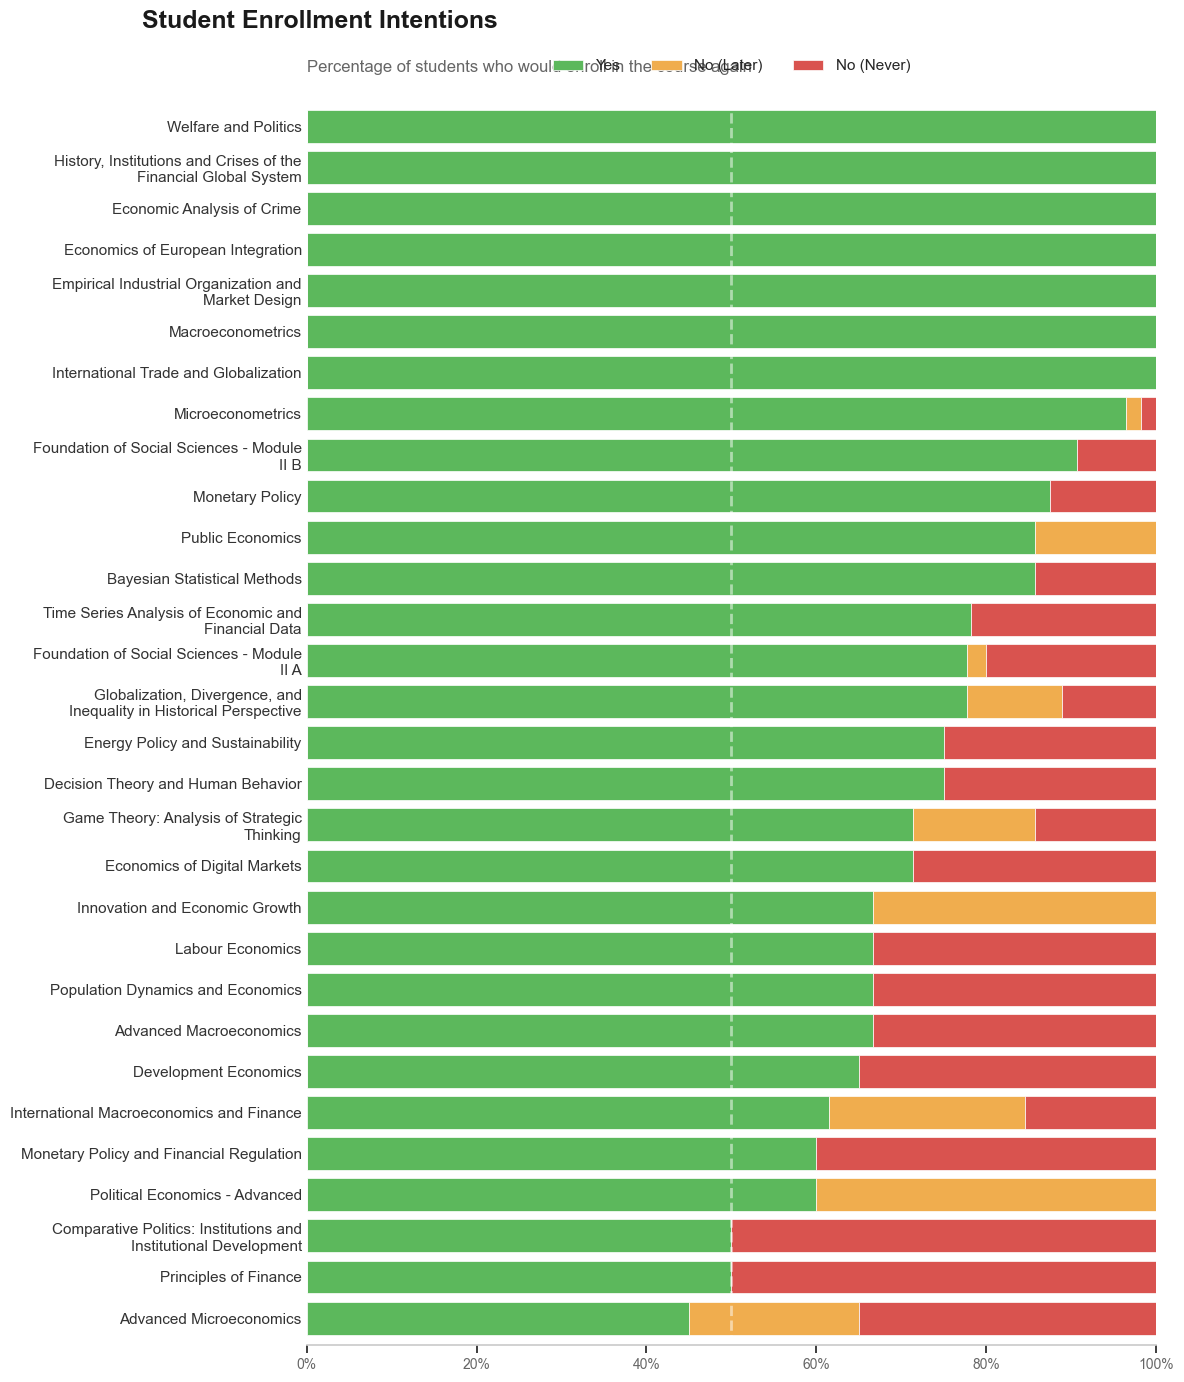

In [44]:
# --- 1. PREPARE DATA ---
# Group by Course and Answer
enroll_counts = long_df.groupby(['Course', 'Enrol Again Text']).size().unstack(fill_value=0)

# Normalize to percentages (0 to 1)
enroll_pct = enroll_counts.div(enroll_counts.sum(axis=1), axis=0)

# Rename columns for cleaner legend
rename_map = {}
for c in enroll_pct.columns:
    if 'Yes' in c:
        rename_map[c] = 'Yes'
    elif 'No, but' in c or 'second year' in c:
        rename_map[c] = 'No (Later)'
    elif 'No' in c:
        rename_map[c] = 'No (Never)'
    else:
        rename_map[c] = c 

enroll_pct = enroll_pct.rename(columns=rename_map)

# Ensure specific column order for stacking: Yes | No (Later) | No (Never)
# We handle missing columns just in case
for col in ['Yes', 'No (Later)', 'No (Never)']:
    if col not in enroll_pct.columns:
        enroll_pct[col] = 0.0
        
enroll_pct = enroll_pct[['Yes', 'No (Later)', 'No (Never)']]

# Sort by 'Yes' percentage so the chart is organized
# Ascending = Highest 'Yes' at the bottom. Descending = Highest 'Yes' at the top.
# Let's sort Descending for "Top Charts" feel (Best at Top)
enroll_pct = enroll_pct.sort_values('Yes', ascending=True) 

# --- 2. SETUP PLOT ---
# Dynamic Height Calculation: Ensure ~0.4 inch per bar for readability
num_courses = len(enroll_pct)
fig_height = max(10, num_courses * 0.5)

fig, ax = plt.subplots(figsize=(12, fig_height))
ax.set_facecolor('white') # Clean white background

# --- 3. PLOT ---
# Professional Colors:
# Green (#5cb85c) - Positive
# Orange (#f0ad4e) - Neutral/Conditional
# Red (#d9534f) - Negative
colors = ['#5cb85c', '#f0ad4e', '#d9534f']

enroll_pct.plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=colors, 
    width=0.8, 
    edgecolor='white', 
    linewidth=0.5
)

# --- 4. FORMATTING (McKinsey Style) ---

# Remove Box/Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) # Floating bars look
ax.spines['bottom'].set_color('#cccccc')

# Y-Axis (Course Names)
# Wrap text to 40 chars to prevent taking up too much horizontal space
ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()], fontsize=11, color='#333333')
ax.tick_params(axis='y', length=0) # Remove tick marks

# X-Axis (Percentages)
ax.set_xlim(0, 1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], color='#666666', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('')

# Add a subtle vertical line at 50% mark for reference
ax.axvline(0.5, color='white', linestyle='--', linewidth=2, alpha=0.5)

# --- 5. TITLES & LEGEND ---
# Main Title (Bold, Dark)
plt.suptitle('Student Enrollment Intentions', 
             x=0.125, y=0.92, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')

# Subtitle (Lighter, Descriptive)
ax.set_title('Percentage of students who would enroll in the course again', 
             x=0, ha='left', fontsize=12, color='#666666', pad=20)

# Legend (Clean, Top Center)
ax.legend(title='', bbox_to_anchor=(0.5, 1.01), loc='lower center', 
          ncol=3, frameon=False, fontsize=11)

# Save and Show
plt.tight_layout(rect=[0, 0, 1, 0.93]) # Make room for the Suptitle
save_path = os.path.join(OUTPUT_DIR, 'enrollment_sentiment_all_mckinsey.png')
plt.savefig(save_path, dpi=300)
print(f"Chart saved to: {save_path}")

plt.show()

### Plot 2: Heatmap of Metrics

Saved plot to: output/heatmap_metrics.png


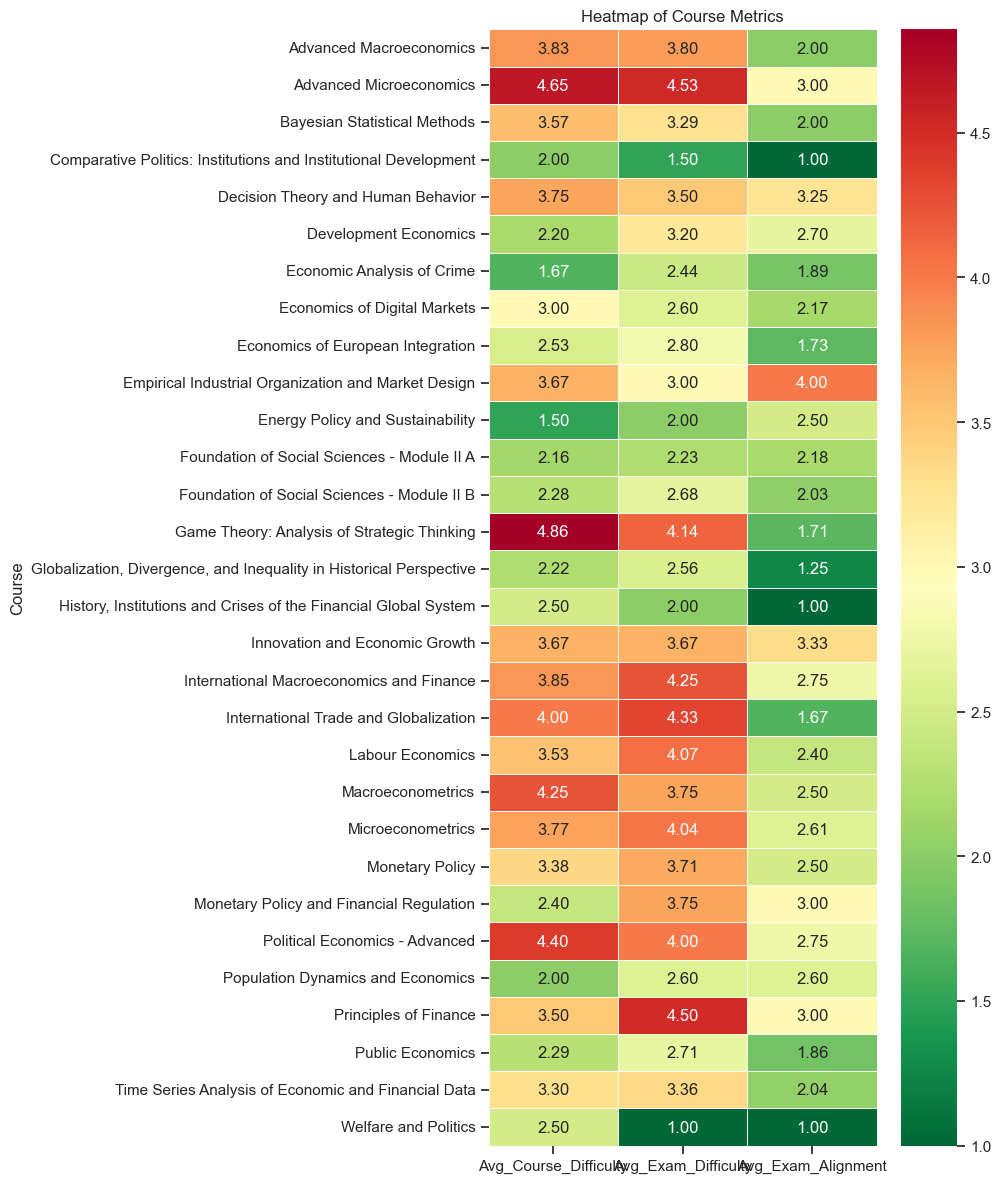

In [45]:
plt.figure(figsize=(10, 12))
heatmap_data = summary.set_index('Course')[['Avg_Course_Difficulty', 'Avg_Exam_Difficulty', 'Avg_Exam_Alignment']]
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Course Metrics')
plt.tight_layout()

# Save Plot 2
plot2_path = os.path.join(OUTPUT_DIR, 'heatmap_metrics.png')
plt.savefig(plot2_path)
print(f"Saved plot to: {plot2_path}")
plt.show()

### Plot 3a: Course difficulty distribution

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2165869378.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2165869378.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2165869378.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])


Violin plot for all courses saved to: output/difficulty_distribution_violin_all.png


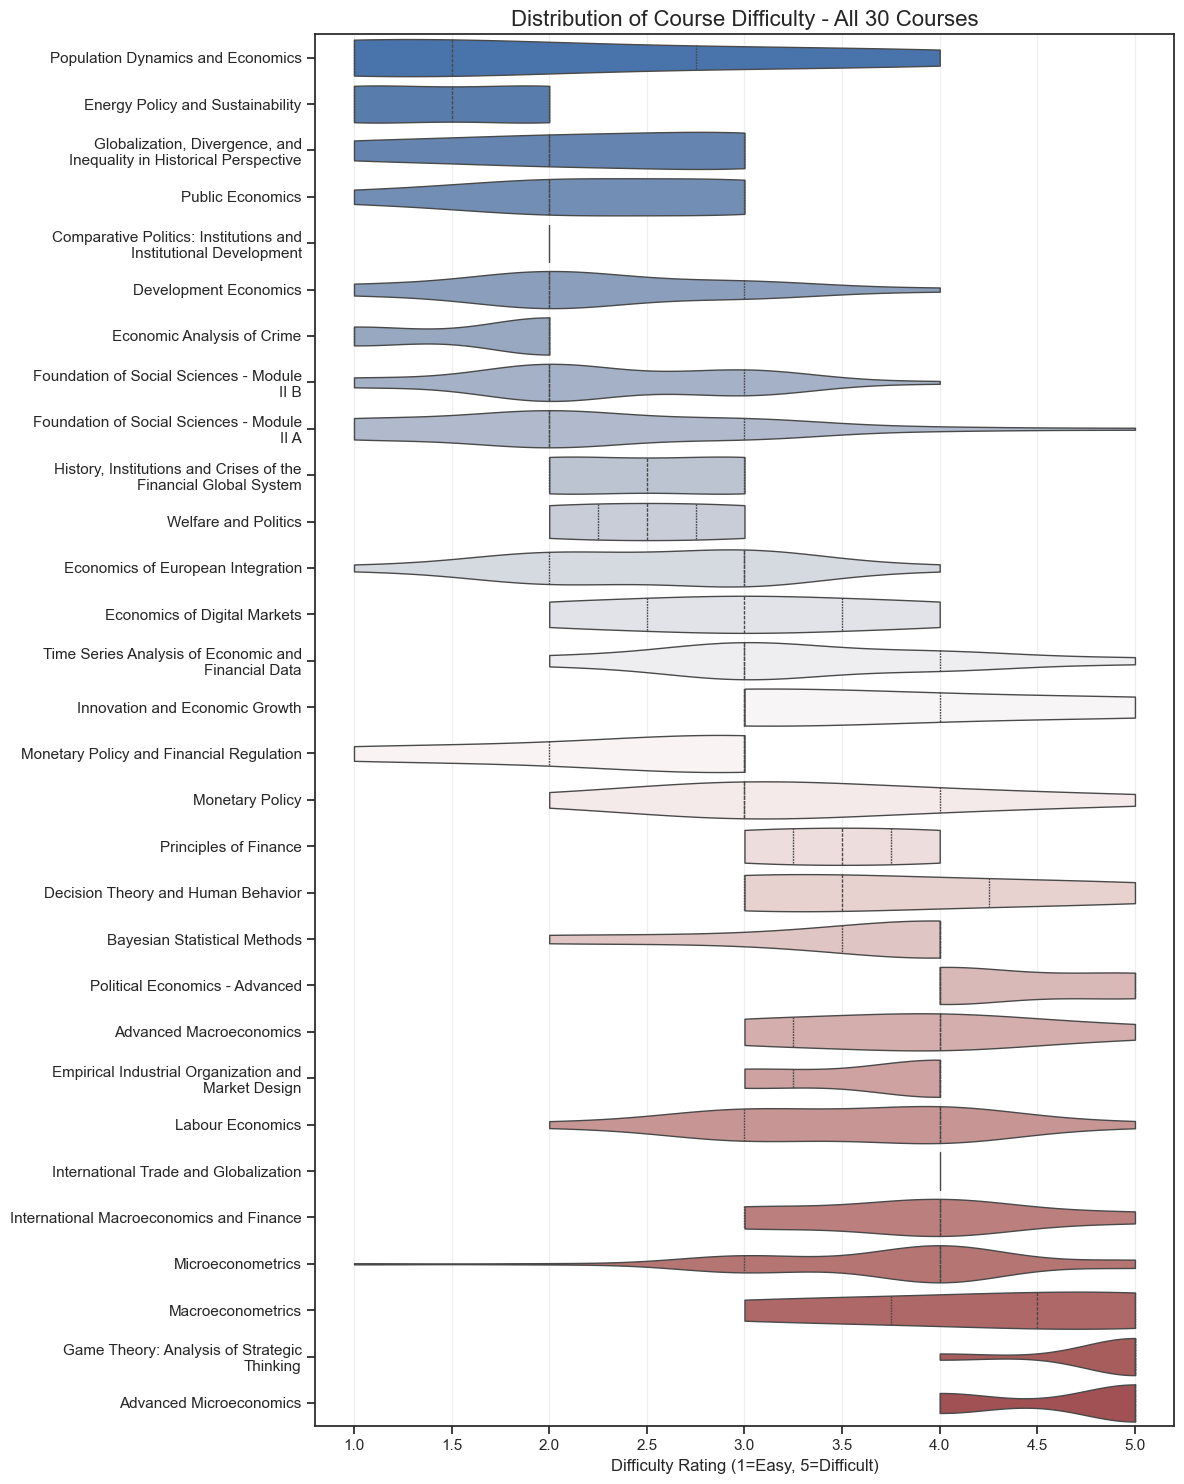

In [46]:
# --- VIOLIN PLOT: ALL COURSES ---

# 1. Use the full dataset (long_df) instead of filtering
df_all = long_df.copy()

# 2. Sort all courses by Median Difficulty
# This ensures the chart is organized from Easy (top) to Hard (bottom) or vice versa
sorted_order = df_all.groupby('Course')['Course Difficulty'].median().sort_values().index

# 3. Calculate Dynamic Height
# Allow 0.5 inches per course, with a minimum height of 10 inches
# This prevents the labels from overlapping when plotting many courses
num_courses = len(sorted_order)
dynamic_height = max(10, num_courses * 0.5)

plt.figure(figsize=(12, dynamic_height))
sns.set_theme(style="ticks")

# 4. Create the Plot
# scale='width': All violins have the same maximum width (easier to see shapes for small classes)
# cut=0: Limits the violin to the data range (1-5)
sns.violinplot(
    data=df_all, 
    x='Course Difficulty', 
    y='Course', 
    order=sorted_order,
    palette="vlag", 
    linewidth=1, 
    cut=0, 
    inner="quartile",
    scale='width' 
)

plt.title(f'Distribution of Course Difficulty - All {num_courses} Courses', fontsize=16)
plt.xlabel('Difficulty Rating (1=Easy, 5=Difficult)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)

# 5. Wrap Y-labels for readability
ax = plt.gca()
# Wrap text at 40 characters to keep the chart clean
ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])

plt.tight_layout()

# Save
save_path = os.path.join(OUTPUT_DIR, 'difficulty_distribution_violin_all.png')
plt.savefig(save_path, dpi=512)
print(f"Violin plot for all courses saved to: {save_path}")

plt.show()

### Plot 3b: Exam difficulty distribution

/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2359385317.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2359385317.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/vb/lkzdt85j7tx9zpynds7hyqhw0000gn/T/ipykernel_58425/2359385317.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])


Exam difficulty plot saved to: output/exam_difficulty_violin_all.png


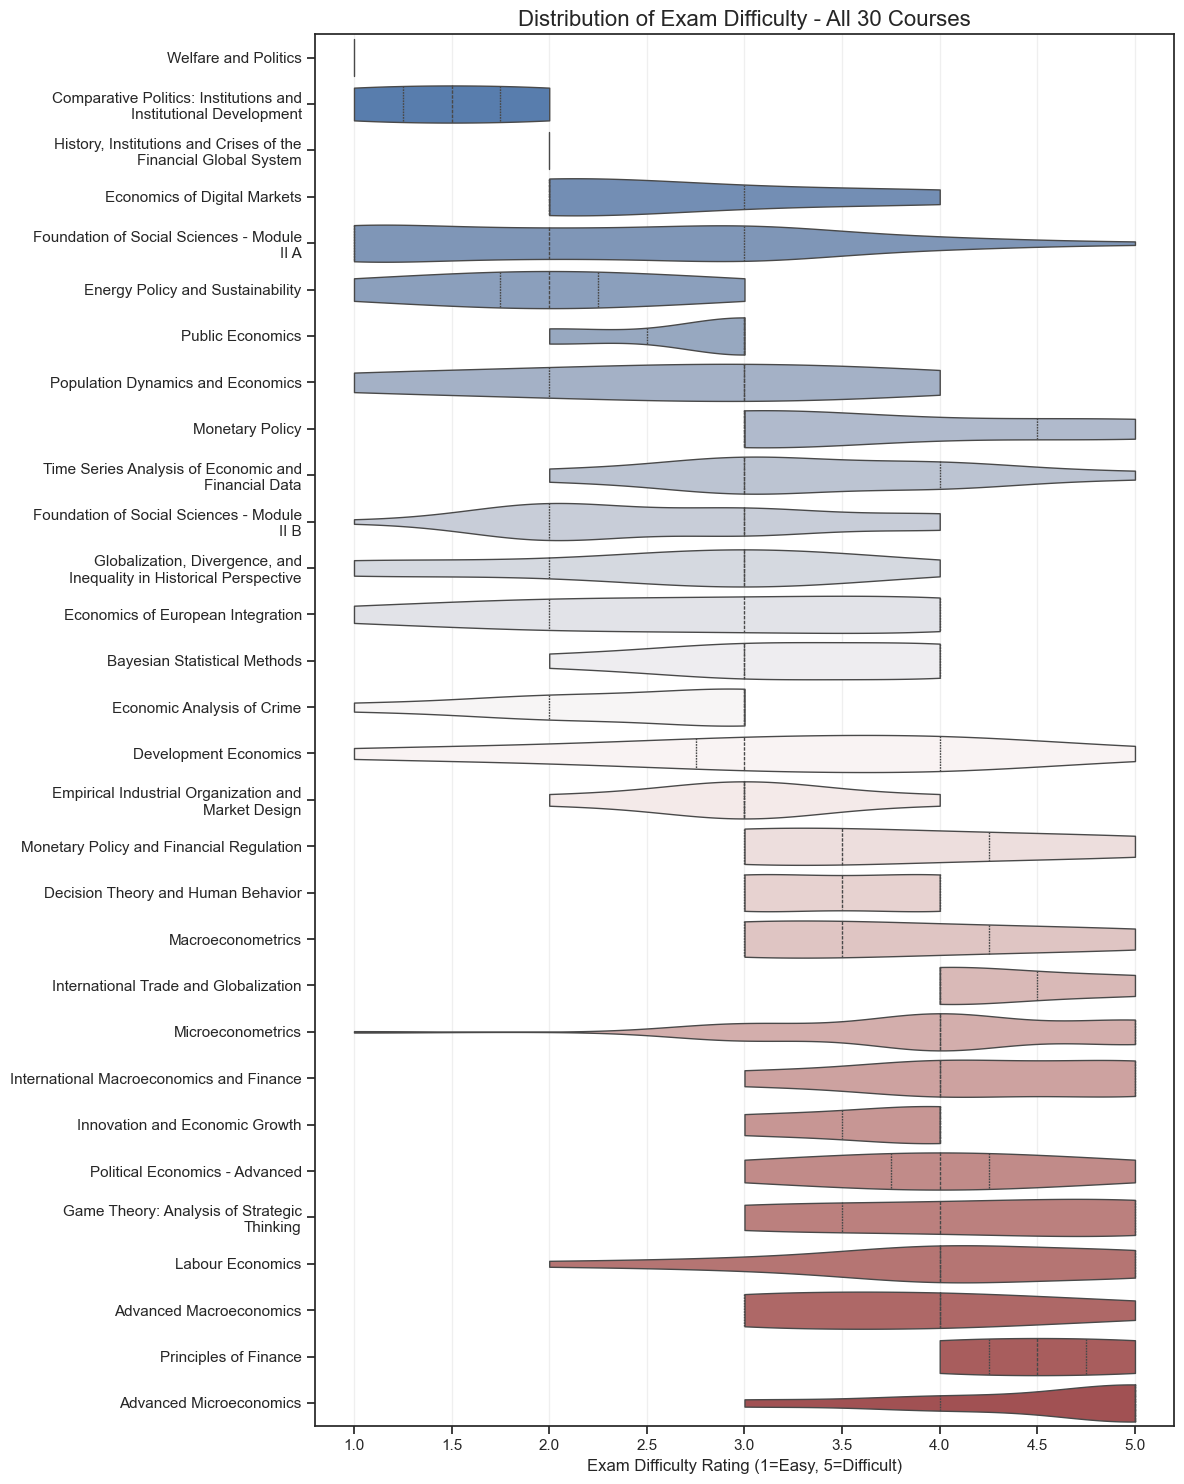

In [47]:
# 1. Prepare Data
# We filter the 'long_df' to strictly rows where we have an Exam Difficulty rating
# (Some students might have rated the course but not the exam)
df_exam = long_df.dropna(subset=['Exam Difficulty']).copy()

# 2. Sort by Median Exam Difficulty
sorted_order = df_exam.groupby('Course')['Exam Difficulty'].median().sort_values().index

# 3. Dynamic Height Calculation
num_courses = len(sorted_order)
dynamic_height = max(10, num_courses * 0.5)

plt.figure(figsize=(12, dynamic_height))
sns.set_theme(style="ticks")

# 4. Create Plot
sns.violinplot(
    data=df_exam, 
    x='Exam Difficulty', 
    y='Course', 
    order=sorted_order,
    palette="vlag", 
    linewidth=1, 
    cut=0, 
    inner="quartile",
    scale='width'
)

plt.title(f'Distribution of Exam Difficulty - All {num_courses} Courses', fontsize=16)
plt.xlabel('Exam Difficulty Rating (1=Easy, 5=Difficult)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)

# 5. Formatting
ax = plt.gca()
ax.set_yticklabels([textwrap.fill(y.get_text(), 40) for y in ax.get_yticklabels()])

plt.tight_layout()

# Save
save_path = os.path.join(OUTPUT_DIR, 'exam_difficulty_violin_all.png')
plt.savefig(save_path, dpi=512)
print(f"Exam difficulty plot saved to: {save_path}")

plt.show()

### Plot 4: "Hard but Fair" scatter plot

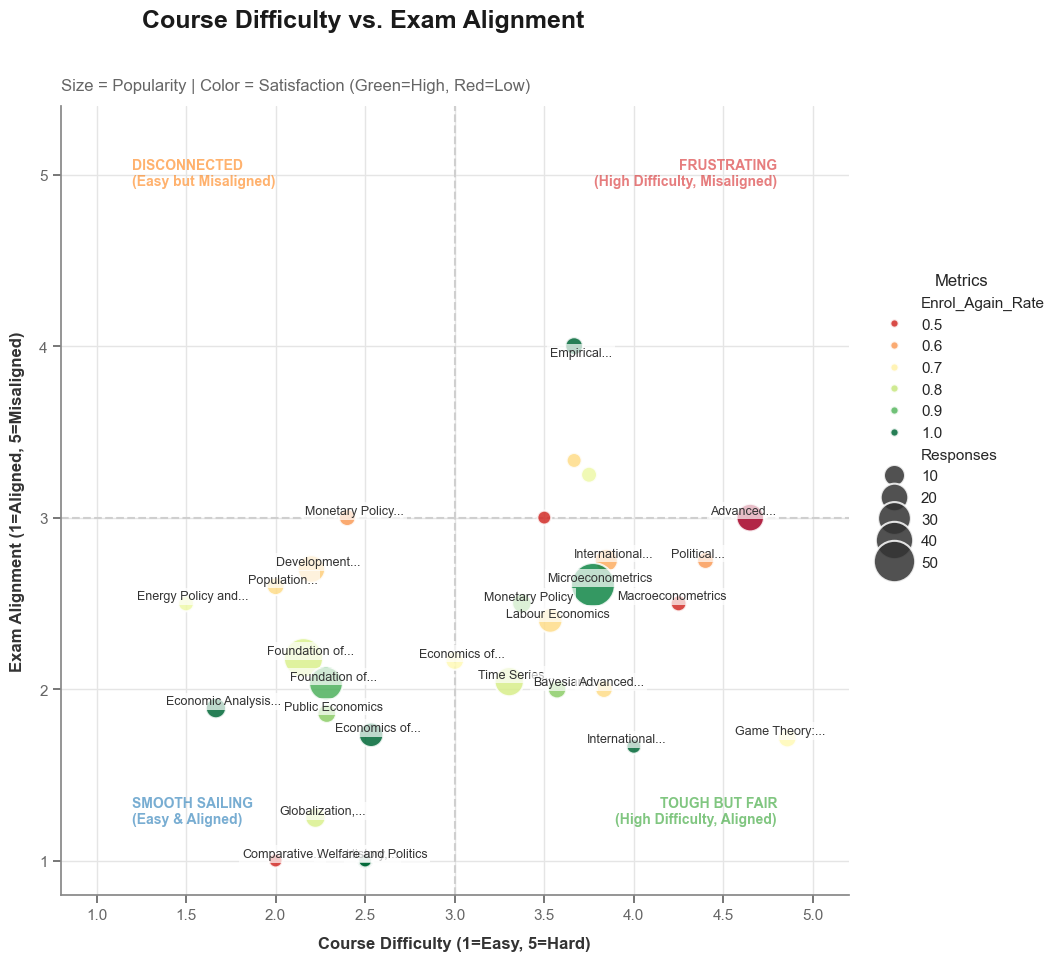

In [48]:
# --- CONFIGURATION ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# --- DATA PREP ---
# We use the 'summary' dataframe from previous steps
# Calculate distance from center (3,3) to identify outliers for labeling
summary['dist_from_neutral'] = np.sqrt((summary['Avg_Course_Difficulty'] - 3)**2 + (summary['Avg_Exam_Alignment'] - 3)**2)

# --- PLOT SETUP ---
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor('white')

# --- QUADRANT LINES ---
# Draw neutral lines at 3.0
ax.axhline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)
ax.axvline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)

# --- SCATTERPLOT ---
sns.scatterplot(
    data=summary,
    x='Avg_Course_Difficulty',
    y='Avg_Exam_Alignment',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=(100, 1000),
    palette='RdYlGn', 
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    ax=ax,
    zorder=2
)

# --- MCKINSEY-STYLE FORMATTING ---

# 1. Clean Axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')
ax.tick_params(axis='both', colors='#666666', labelsize=11)
ax.grid(True, which='major', color='#e5e5e5', linestyle='-', zorder=0)

# 2. Axis Labels (UPDATED for Inverted Scale)
ax.set_xlabel('Course Difficulty (1=Easy, 5=Hard)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')
ax.set_ylabel('Exam Alignment (1=Aligned, 5=Misaligned)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')

# 3. Set Limits
ax.set_xlim(0.8, 5.2)
ax.set_ylim(0.8, 5.4)

# --- SMART ANNOTATIONS ---
# Label points that are far from neutral OR very popular
interesting_points = summary[
    (summary['Responses'] >= 5) | (summary['dist_from_neutral'] > 1.2)
].sort_values('Responses', ascending=False)

texts = []
for i, row in interesting_points.iterrows():
    label = textwrap.shorten(row['Course'], width=20, placeholder="...")
    
    # Nudge logic
    x_offset = 0.08 if row['Avg_Course_Difficulty'] < 4 else -0.08
    y_offset = 0.08 if row['Avg_Exam_Alignment'] < 4 else -0.08
    
    ax.text(
        row['Avg_Course_Difficulty'] + (x_offset/2),
        row['Avg_Exam_Alignment'] + (y_offset/2),
        label,
        fontsize=9,
        color='#333333',
        weight='medium',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
        ha='center', va='center',
        zorder=3
    )

# --- QUADRANT TITLES (UPDATED) ---

# Top-Right: High Diff + High Score (Misaligned) -> BAD
ax.text(4.8, 5.1, "FRUSTRATING\n(High Difficulty, Misaligned)", 
        ha='right', va='top', fontsize=10, color='#d62728', fontweight='bold', alpha=0.6)

# Bottom-Right: High Diff + Low Score (Aligned) -> GOOD/FAIR
ax.text(4.8, 1.2, "TOUGH BUT FAIR\n(High Difficulty, Aligned)", 
        ha='right', va='bottom', fontsize=10, color='#2ca02c', fontweight='bold', alpha=0.6)

# Bottom-Left: Low Diff + Low Score (Aligned) -> SMOOTH
ax.text(1.2, 1.2, "SMOOTH SAILING\n(Easy & Aligned)", 
        ha='left', va='bottom', fontsize=10, color='#1f77b4', fontweight='bold', alpha=0.6)

# Top-Left: Low Diff + High Score (Misaligned) -> CONFUSING
ax.text(1.2, 5.1, "DISCONNECTED\n(Easy but Misaligned)", 
        ha='left', va='top', fontsize=10, color='#ff7f0e', fontweight='bold', alpha=0.6)

# --- TITLE & LEGEND ---
plt.suptitle('Course Difficulty vs. Exam Alignment', 
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
plt.title('Size = Popularity | Color = Satisfaction (Green=High, Red=Low)', 
          x=0.0, y=1.01, ha='left', fontsize=12, color='#666666')

plt.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(os.path.join(OUTPUT_DIR, 'mckinsey_bubble_chart_corrected.png'), dpi=512)
plt.show()

### Plot 4b: Exam difficulty vs. Exam alignment scatter plot

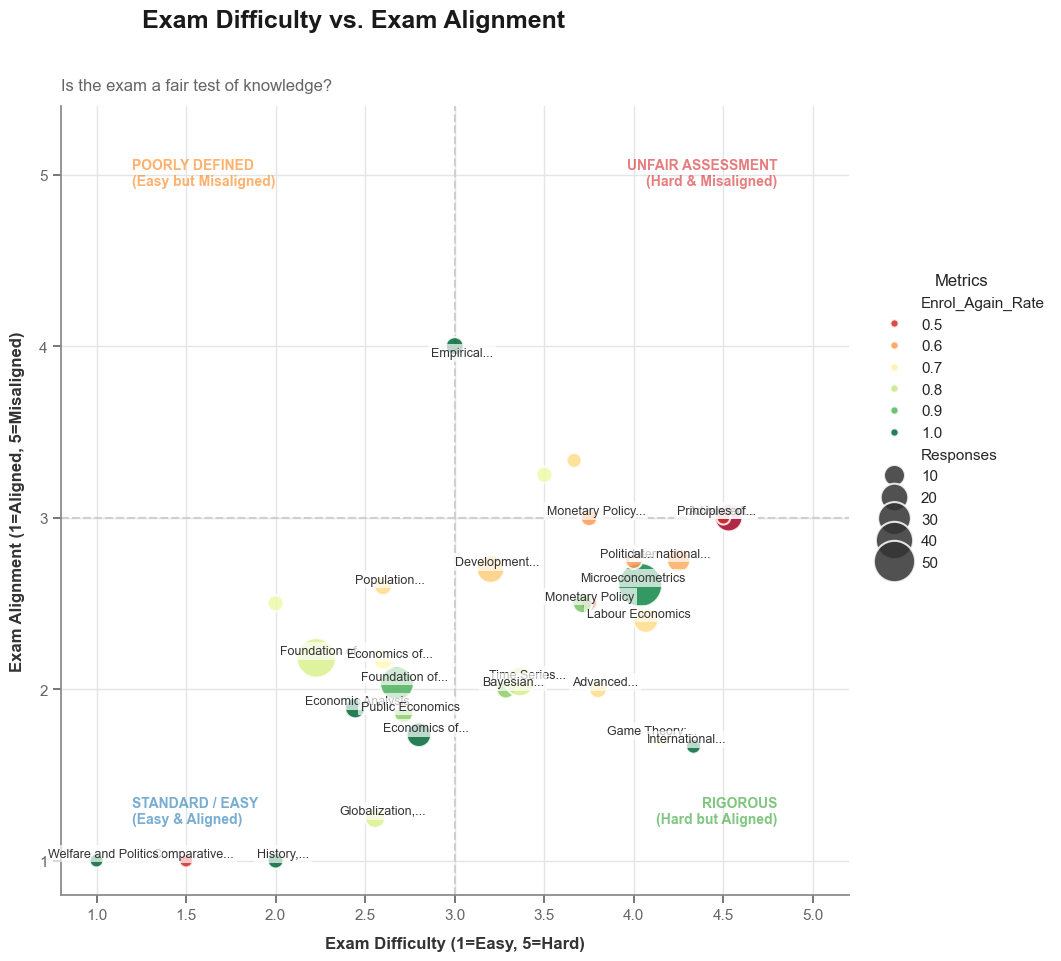

In [49]:
# Prepare Data
# Calculate distance from center (3,3) for labeling outliers
summary['dist_exam_mismatch'] = np.sqrt((summary['Avg_Exam_Difficulty'] - 3)**2 + (summary['Avg_Exam_Alignment'] - 3)**2)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor('white')

# Quadrant Lines
ax.axhline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)
ax.axvline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)

# Scatterplot
sns.scatterplot(
    data=summary,
    x='Avg_Exam_Difficulty',
    y='Avg_Exam_Alignment',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=(100, 1000),
    palette='RdYlGn', 
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    ax=ax,
    zorder=2
)

# Formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')
ax.tick_params(axis='both', colors='#666666', labelsize=11)
ax.grid(True, which='major', color='#e5e5e5', linestyle='-', zorder=0)

# Labels
ax.set_xlabel('Exam Difficulty (1=Easy, 5=Hard)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')
ax.set_ylabel('Exam Alignment (1=Aligned, 5=Misaligned)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')
ax.set_xlim(0.8, 5.2)
ax.set_ylim(0.8, 5.4)

# Smart Annotations
interesting_points = summary[
    (summary['Responses'] >= 5) | (summary['dist_exam_mismatch'] > 1.2)
].sort_values('Responses', ascending=False)

for i, row in interesting_points.iterrows():
    label = textwrap.shorten(row['Course'], width=20, placeholder="...")
    # Nudge logic
    x_offset = 0.08 if row['Avg_Exam_Difficulty'] < 4 else -0.08
    y_offset = 0.08 if row['Avg_Exam_Alignment'] < 4 else -0.08
    
    ax.text(
        row['Avg_Exam_Difficulty'] + (x_offset/2),
        row['Avg_Exam_Alignment'] + (y_offset/2),
        label,
        fontsize=9, color='#333333', weight='medium',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
        ha='center', va='center', zorder=3
    )

# Quadrant Titles
ax.text(4.8, 5.1, "UNFAIR ASSESSMENT\n(Hard & Misaligned)", 
        ha='right', va='top', fontsize=10, color='#d62728', fontweight='bold', alpha=0.6)
ax.text(4.8, 1.2, "RIGOROUS\n(Hard but Aligned)", 
        ha='right', va='bottom', fontsize=10, color='#2ca02c', fontweight='bold', alpha=0.6)
ax.text(1.2, 1.2, "STANDARD / EASY\n(Easy & Aligned)", 
        ha='left', va='bottom', fontsize=10, color='#1f77b4', fontweight='bold', alpha=0.6)
ax.text(1.2, 5.1, "POORLY DEFINED\n(Easy but Misaligned)", 
        ha='left', va='top', fontsize=10, color='#ff7f0e', fontweight='bold', alpha=0.6)

# Titles
plt.suptitle('Exam Difficulty vs. Exam Alignment', 
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
plt.title('Is the exam a fair test of knowledge?', 
          x=0.0, y=1.01, ha='left', fontsize=12, color='#666666')
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(os.path.join(OUTPUT_DIR, 'exam_difficulty_vs_alignment.png'), dpi=512)
plt.show()

### Plot 4c: Course difficulty vs Exam difficulty scatter plot

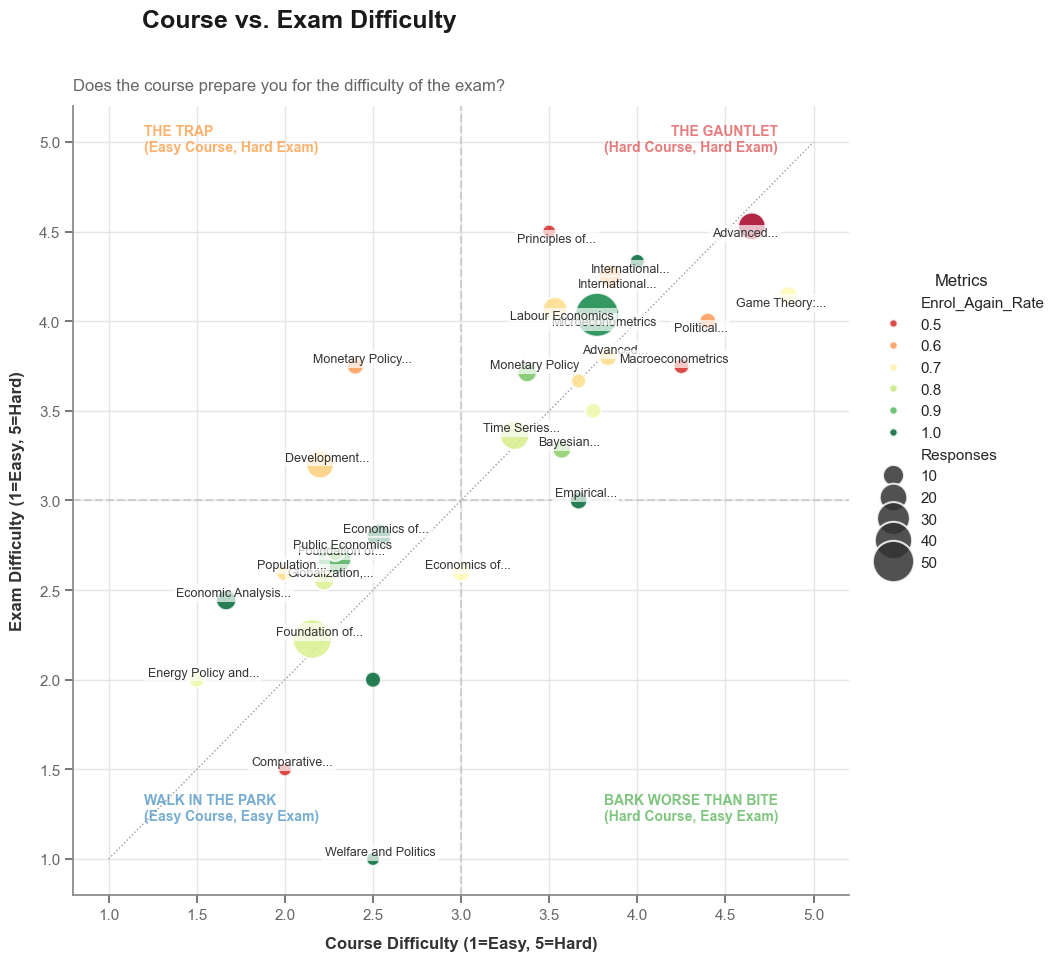

In [50]:
# Calculate distance
summary['dist_diff_mismatch'] = np.sqrt((summary['Avg_Course_Difficulty'] - 3)**2 + (summary['Avg_Exam_Difficulty'] - 3)**2)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor('white')

# Quadrant Lines
ax.axhline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)
ax.axvline(3, color='#cfcfcf', linestyle='--', linewidth=1.5, zorder=1)
# Add diagonal line (y=x) to show perfect match
ax.plot([1, 5], [1, 5], ls=':', c='#999999', lw=1, zorder=1)

# Scatterplot
sns.scatterplot(
    data=summary,
    x='Avg_Course_Difficulty',
    y='Avg_Exam_Difficulty',
    size='Responses',
    hue='Enrol_Again_Rate',
    sizes=(100, 1000),
    palette='RdYlGn', 
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    ax=ax,
    zorder=2
)

# Formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')
ax.tick_params(axis='both', colors='#666666', labelsize=11)
ax.grid(True, which='major', color='#e5e5e5', linestyle='-', zorder=0)

# Labels
ax.set_xlabel('Course Difficulty (1=Easy, 5=Hard)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')
ax.set_ylabel('Exam Difficulty (1=Easy, 5=Hard)', fontsize=12, fontweight='bold', labelpad=10, color='#333333')
ax.set_xlim(0.8, 5.2)
ax.set_ylim(0.8, 5.2)

# Smart Annotations
interesting_points = summary[
    (summary['Responses'] >= 5) | (summary['dist_diff_mismatch'] > 1.2)
].sort_values('Responses', ascending=False)

for i, row in interesting_points.iterrows():
    label = textwrap.shorten(row['Course'], width=20, placeholder="...")
    x_offset = 0.08 if row['Avg_Course_Difficulty'] < 4 else -0.08
    y_offset = 0.08 if row['Avg_Exam_Difficulty'] < 4 else -0.08
    
    ax.text(
        row['Avg_Course_Difficulty'] + (x_offset/2),
        row['Avg_Exam_Difficulty'] + (y_offset/2),
        label,
        fontsize=9, color='#333333', weight='medium',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
        ha='center', va='center', zorder=3
    )

# Quadrant Titles
ax.text(4.8, 5.1, "THE GAUNTLET\n(Hard Course, Hard Exam)", 
        ha='right', va='top', fontsize=10, color='#d62728', fontweight='bold', alpha=0.6)
ax.text(4.8, 1.2, "BARK WORSE THAN BITE\n(Hard Course, Easy Exam)", 
        ha='right', va='bottom', fontsize=10, color='#2ca02c', fontweight='bold', alpha=0.6)
ax.text(1.2, 1.2, "WALK IN THE PARK\n(Easy Course, Easy Exam)", 
        ha='left', va='bottom', fontsize=10, color='#1f77b4', fontweight='bold', alpha=0.6)
ax.text(1.2, 5.1, "THE TRAP\n(Easy Course, Hard Exam)", 
        ha='left', va='top', fontsize=10, color='#ff7f0e', fontweight='bold', alpha=0.6)

# Titles
plt.suptitle('Course vs. Exam Difficulty', 
             x=0.125, y=0.96, ha='left', fontsize=18, fontweight='bold', color='#1a1a1a')
plt.title('Does the course prepare you for the difficulty of the exam?', 
          x=0.0, y=1.01, ha='left', fontsize=12, color='#666666')
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='center left', frameon=False, title="Metrics")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(os.path.join(OUTPUT_DIR, 'course_vs_exam_difficulty.png'), dpi=512)
plt.show()